In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import gmean, hmean
import warnings
np.set_printoptions(threshold=np.inf)
warnings.simplefilter('ignore')
sns.set()
%config InlineBackend.figure_format = 'retina'

#Data preprocessing

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
#Converting galaxies into categores
#Droping galaxy 126 as it have only one sample and only in train
df = pd.concat([train,test], sort=False)
df["galaxy"] = df["galaxy"].astype('category')
df["galaxy"] = df["galaxy"].cat.codes
df_train = df[:3865]
df_test = df[3865:]
df_train = df_train.drop(df.index[144]).reset_index(drop=True)
df_test = df_test.drop("y", axis = 1)

In [ ]:
print('Total unique galaxies in train:', len(df_train['galaxy'].unique()))
print('Total unique galaxies in test:', len(df_test['galaxy'].unique()))

Total unique galaxies in train: 180
Total unique galaxies in test: 172


In [ ]:
print("Train size: " + str(train.shape))
print("Test size: " + str(test.shape))

Train size: (3865, 80)
Test size: (890, 79)


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3864 entries, 0 to 3863
Data columns (total 80 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   galactic year                                                                            3864 non-null   int64  
 1   galaxy                                                                                   3864 non-null   int16  
 2   existence expectancy index                                                               3864 non-null   float64
 3   existence expectancy at birth                                                            3864 non-null   float64
 4   Gross income per capita                                                                  3836 non-null   float64
 5   Income Index                                                  

#Filling NA values 
Main idea was to fill indexes according to http://hdr.undp.org/sites/default/files/hdr2019_technical_notes.pdf, so we can use that indexes to predict target variable as it a composition index itself. <br>
To fill features that got NAs and that were part of formulas to calculate our main indexes, i used  regression. So basically i filled NA values using xgboost regressor.

##Filling NA values of Intergalactic Development Index (IDI)

In [ ]:
#Заполняем Expected years of education (galactic years), Mean years of education (galactic years) и Gross capital formation (% of GGP) мианами по галактикам
df_train['Gross income per capita'] = df_train.groupby('galaxy')['Gross income per capita'].apply(lambda x: x.fillna(x.mean()))
df_train['Mean years of education (galactic years)'] = df_train.groupby('galaxy')['Mean years of education (galactic years)'].apply(lambda x: x.fillna(x.mean()))
df_train['Expected years of education (galactic years)'] = df_train.groupby('galaxy')['Expected years of education (galactic years)'].apply(lambda x: x.fillna(x.mean()))

In [ ]:
# Заполняем Education Index
min_val_exp = round(df_train['Expected years of education (galactic years)'].min())
min_val_mean = round(df_train['Mean years of education (galactic years)'].min())
max_val_exp = round(df_train['Expected years of education (galactic years)'].max())
max_val_mean = round(df_train['Mean years of education (galactic years)'].max())
df_train['Expected years of education index'] = (df_train['Expected years of education (galactic years)'] - min_val_exp)/(max_val_exp - min_val_exp)
df_train['Mean years of education index'] = (df_train['Mean years of education (galactic years)'] - min_val_mean)/(max_val_mean - min_val_mean)
df_train['Education Index'] = df_train.groupby('galaxy')['Education Index'].fillna((df_train['Expected years of education index'] + df_train['Mean years of education index'])/2)

In [ ]:
# Заполняем Income Index
min_val_gi_per_capita = 1000
max_val_gi_per_capita = 75000
df_train['Income Index'] = df_train.groupby('galaxy')['Income Index'].fillna((np.log(df_train['Gross income per capita']) - np.log(min_val_gi_per_capita))/(max_val_gi_per_capita - min_val_gi_per_capita))

In [ ]:
#Создаем Health Index
df_train['Health Index'] = (df_train['existence expectancy at birth'] - 30)/(100 - 30)

In [ ]:
#Заполняем Intergalactic Development Index (IDI)  
df_train['Intergalactic Development Index (IDI)'] = df_train['Intergalactic Development Index (IDI)'].fillna((df_train['Education Index'] * df_train['Income Index'] * df_train['Health Index']) ** (1/3))

##Function to fill columns with regression

In [ ]:
def fill_nan_with_reg(data, features, columns_to_reg_on):
    data = data.drop(['galaxy'], axis=1)
    df_train_not_nan = data.loc[:, columns_to_reg_on]

    for feature in features:
      na_index = data[data.loc[:,feature].isnull()][feature].index
      not_na_index = data[data.loc[:,feature].notnull()][feature].index
      x_train = df_train_not_nan.iloc[not_na_index]
      y_train = data.loc[not_na_index,feature]
      x_test = df_train_not_nan.iloc[na_index]

      model = XGBRegressor(n_estimators=500, learning_rate=0.08, max_depth=4).fit(x_train, y_train)
      pred = model.predict(x_test)

      ser = pd.Series(pred, index = na_index)
      feature_with_no_na = y_train.append(ser).sort_index()

      df_train_not_nan[feature] = feature_with_no_na

    return df_train_not_nan

##Filling GDI

###Filling Estimated female/male earned income index

In [ ]:
df_train.loc[df_train['Estimated gross galactic income per capita, female'] < 0, 'Estimated gross galactic income per capita, female'] = 100

In [145]:
correlation_2 = abs(df_train.corrwith(df_train['Estimated gross galactic income per capita, male']))
columns_2 = list(correlation_2.nlargest(15).index)[1:]

In [ ]:
features_to_fill = ['Estimated gross galactic income per capita, male', 'Estimated gross galactic income per capita, female']
cols_to_reg_on = ['Gross income per capita', 'Gross galactic product (GGP) per capita', 'Income Index',  'Intergalactic Development Index (IDI), Rank', 'Intergalactic Development Index (IDI)']

df_train_not_nan = fill_nan_with_reg(df_train, features_to_fill, cols_to_reg_on)

not_nan_cols = df_train_not_nan.columns
df_train[not_nan_cols] = df_train_not_nan[not_nan_cols]

[10:25:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
df_train['Estimated female earned income index'] = (np.log(df_train['Estimated gross galactic income per capita, female']) - np.log(100)) / (np.log(75000) - np.log(100))
df_train['Estimated male earned income index'] = (np.log(df_train['Estimated gross galactic income per capita, male']) - np.log(100)) / (np.log(75000) - np.log(100))

###Flling Female/male health index

In [ ]:
df_train['Mortality rate, under-five (per 1,000 live births)'] = df_train['Mortality rate, under-five (per 1,000 live births)'] + df_train['Mortality rate, infant (per 1,000 live births)']
df_train = df_train.drop('Mortality rate, infant (per 1,000 live births)', axis=1)

In [146]:
correlation_2 = abs(df_train.corrwith(df_train['Mortality rate, under-five (per 1,000 live births)']))
columns_2 = list(correlation_2.nlargest(15).index)[1:]

In [ ]:
features_to_fill_2 = ['Mortality rate, under-five (per 1,000 live births)']
cols_to_reg_on = ['existence expectancy index', 'Health Index', 'existence expectancy at birth', 'Intergalactic Development Index (IDI)']

df_train_not_nan = fill_nan_with_reg(df_train, features_to_fill_2, cols_to_reg_on)

not_nan_cols = df_train_not_nan.columns
df_train[not_nan_cols] = df_train_not_nan[not_nan_cols]

[10:25:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [147]:
correlation_2 = abs(df_train.corrwith(df_train['Life expectancy at birth, female (galactic years)']))
columns_2 = list(correlation_2.nlargest(15).index)[1:]

In [ ]:
features_to_fill_2 = ['Life expectancy at birth, female (galactic years)', 'Life expectancy at birth, male (galactic years)']
cols_to_reg_on = ['existence expectancy index', 'Health Index', 'existence expectancy at birth', 'Intergalactic Development Index (IDI)', 'Mortality rate, under-five (per 1,000 live births)']

df_train_not_nan = fill_nan_with_reg(df_train, features_to_fill_2, cols_to_reg_on)

not_nan_cols = df_train_not_nan.columns
df_train[not_nan_cols] = df_train_not_nan[not_nan_cols]

[10:25:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
df_train['Female health index'] = (df_train['Life expectancy at birth, female (galactic years)'] - 30) / (88 - 30)
df_train['Male health index'] = (df_train['Life expectancy at birth, male (galactic years)'] - 30) / (88 - 30)

###Filling Female/male education index

In [148]:
correlation_2 = abs(df_train.corrwith(df_train['Population with at least some secondary education (% ages 25 and older)']))
columns_2 = list(correlation_2.nlargest(15).index)[1:]

In [ ]:
features_to_fill = ['Population with at least some secondary education (% ages 25 and older)', 'Population with at least some secondary education, female (% ages 25 and older)',
                    'Population with at least some secondary education, male (% ages 25 and older)']
cols_to_reg_on = ['Mean years of education index', 'Education Index', 'Intergalactic Development Index (IDI)']

df_train_not_nan = fill_nan_with_reg(df_train, features_to_fill, cols_to_reg_on)

not_nan_cols = df_train_not_nan.columns
df_train[not_nan_cols] = df_train_not_nan[not_nan_cols]

[10:25:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [149]:
correlation_2 = abs(df_train.corrwith(df_train['Mean years of education, female (galactic years)']))
columns_2 = list(correlation_2.nlargest(15).index)[1:]

In [ ]:
features_to_fill = ['Mean years of education, female (galactic years)', 'Mean years of education, male (galactic years)',
                    'Expected years of education, female (galactic years)', 'Expected years of education, male (galactic years)']
cols_to_reg_on = ['Mean years of education index', 'Population with at least some secondary education, female (% ages 25 and older)', 'Education Index', 
                  'Population with at least some secondary education (% ages 25 and older)', 'Population with at least some secondary education, male (% ages 25 and older)', 
                  'Intergalactic Development Index (IDI)']

df_train_not_nan = fill_nan_with_reg(df_train, features_to_fill, cols_to_reg_on)

not_nan_cols = df_train_not_nan.columns
df_train[not_nan_cols] = df_train_not_nan[not_nan_cols]

[10:25:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
df_train['Female education index'] = ((df_train['Expected years of education, female (galactic years)']/25) + (df_train['Mean years of education, female (galactic years)']/18))/2
df_train['Male education index'] = ((df_train['Expected years of education, male (galactic years)']/25) + (df_train['Mean years of education, male (galactic years)']/18))/2

In [ ]:
def fill_with_gmean(data, feature, gmean_vals):
  na_index = data[data.loc[:,feature].isnull()][feature].index
  gmean_arr = gmean_vals

  ser = pd.Series(gmean_arr[na_index], index = na_index)
  feature_with_no_na = data[data.loc[:,feature].notnull()][feature].append(ser).sort_index()

  return feature_with_no_na

In [ ]:
male_gmean = gmean(df_train.loc[:,['Male education index', 'Male health index', 'Estimated male earned income index']], axis = 1)
female_gmean = gmean(df_train.loc[:,['Female education index', 'Female health index', 'Estimated female earned income index']], axis = 1)

In [ ]:
df_train['Intergalactic Development Index (IDI), male'] = fill_with_gmean(df_train, 'Intergalactic Development Index (IDI), male', male_gmean)
df_train['Intergalactic Development Index (IDI), female'] = fill_with_gmean(df_train, 'Intergalactic Development Index (IDI), female', female_gmean)

In [ ]:
df_train['Gender Development Index (GDI)'] = df_train['Gender Development Index (GDI)'].fillna(df_train['Intergalactic Development Index (IDI), male'] / df_train['Intergalactic Development Index (IDI), female'])

##Filling GII

In [ ]:
features_to_fill = ['Young age (0-14) dependency ratio (per 100 creatures ages 15-64)']
cols_to_reg_on = ['Intergalactic Development Index (IDI), female', 'Intergalactic Development Index (IDI), male', 'Female education index',
                  'Intergalactic Development Index (IDI)', 'Female health index', 'Life expectancy at birth, female (galactic years)', 'Gender Inequality Index (GII)','Male education index']

df_train_not_nan = fill_nan_with_reg(df_train, features_to_fill, cols_to_reg_on)

not_nan_cols = df_train_not_nan.columns
df_train[not_nan_cols] = df_train_not_nan[not_nan_cols]

[10:25:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
features_to_fill = ['Maternal mortality ratio (deaths per 100,000 live births)']
cols_to_reg_on = ['Mortality rate, under-five (per 1,000 live births)', 'Female health index', 'Life expectancy at birth, female (galactic years)',
 'existence expectancy at birth', 'Health Index', 'existence expectancy index', 'Life expectancy at birth, male (galactic years)', 'Male health index']

df_train_not_nan = fill_nan_with_reg(df_train, features_to_fill, cols_to_reg_on)
not_nan_cols = df_train_not_nan.columns
df_train[not_nan_cols] = df_train_not_nan[not_nan_cols]

[10:25:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
features_to_fill = ['Adolescent birth rate (births per 1,000 female creatures ages 15-19)']
cols_to_reg_on = ['Mortality rate, under-five (per 1,000 live births)', 'Young age (0-14) dependency ratio (per 100 creatures ages 15-64)', 'existence expectancy at birth',
 'Health Index', 'Life expectancy at birth, female (galactic years)', 'Female health index', 'Intergalactic Development Index (IDI), male']

df_train_not_nan = fill_nan_with_reg(df_train, features_to_fill, cols_to_reg_on)
not_nan_cols = df_train_not_nan.columns
df_train[not_nan_cols] = df_train_not_nan[not_nan_cols]

[10:25:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
features_to_fill = ['Interstellar Data Net users, total (% of population)']
cols_to_reg_on = ['Intergalactic Development Index (IDI), male', 'Male education index', 'Intergalactic Development Index (IDI), female', 'Female education index',
 'Intergalactic Development Index (IDI)', 'Education Index']

df_train_not_nan = fill_nan_with_reg(df_train, features_to_fill, cols_to_reg_on)
not_nan_cols = df_train_not_nan.columns
df_train[not_nan_cols] = df_train_not_nan[not_nan_cols]

[10:25:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
features_to_fill = ['Share of seats in senate (% held by female)']
cols_to_reg_on = ['Interstellar Data Net users, total (% of population)', 'galactic year', 'Expected years of education, male (galactic years)', 'Expected years of education (galactic years)',
 'Expected years of education index', 'Expected years of education, female (galactic years)', 'Education Index']

df_train_not_nan = fill_nan_with_reg(df_train, features_to_fill, cols_to_reg_on)
not_nan_cols = df_train_not_nan.columns
df_train[not_nan_cols] = df_train_not_nan[not_nan_cols]

[10:25:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
features_to_fill = ['Labour force participation rate (% ages 15 and older), male', 'Labour force participation rate (% ages 15 and older), female']
cols_to_reg_on = ['Population with at least some secondary education (% ages 25 and older)', 'Mean years of education, male (galactic years)',
                  'Population with at least some secondary education, male (% ages 25 and older)','Male education index','Mean years of education (galactic years)',
                  'Mean years of education index', 'Population with at least some secondary education, female (% ages 25 and older)', 'Education Index']

df_train_not_nan = fill_nan_with_reg(df_train, features_to_fill, cols_to_reg_on)
not_nan_cols = df_train_not_nan.columns
df_train[not_nan_cols] = df_train_not_nan[not_nan_cols]

[10:25:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
df_train['Share of seats in senate (% held by male)'] = (1 - df_train['Share of seats in senate (% held by female)'] / 100) * 100

Reproductive_health_index_female = np.sqrt((10/df_train['Maternal mortality ratio (deaths per 100,000 live births)'])*(1/df_train['Adolescent birth rate (births per 1,000 female creatures ages 15-19)']))
Reproductive_health_index_male = [1] * df_train.shape[0]

Empowerment_index_female = np.sqrt((df_train['Share of seats in senate (% held by female)'] / 100)*(df_train['Population with at least some secondary education, female (% ages 25 and older)'] / 100))
Empowerment_index_male = np.sqrt((df_train['Share of seats in senate (% held by male)'] / 100)*(df_train['Population with at least some secondary education, male (% ages 25 and older)'] / 100))

Labour_Market_Index_female = df_train['Labour force participation rate (% ages 15 and older), female'] /100
Labour_Market_Index_male = df_train['Labour force participation rate (% ages 15 and older), male'] / 100


Gender_indices_female =  (Reproductive_health_index_female * Empowerment_index_female * Labour_Market_Index_female) ** (1/3)
Gender_indices_male = (Reproductive_health_index_male * Empowerment_index_male * Labour_Market_Index_male) ** (1/3)


Accounting_inequality = pd.Series(hmean(pd.DataFrame(zip(Gender_indices_female, Gender_indices_male)), axis=1))

Treating_equally = (((Reproductive_health_index_female + Reproductive_health_index_male)/2)*
                    ((Empowerment_index_female + Empowerment_index_male)/2)*
                    ((Labour_Market_Index_female+Labour_Market_Index_male)/2))**(1/3)


df_train['Gender Inequality Index (GII)'] = df_train['Gender Inequality Index (GII)'].fillna(1 - (Accounting_inequality / Treating_equally))

#Cross-validation
Method to cross-validate and then predict that is used in final submission:
*   I trained model for every galaxy separatly, so 180 models in total;
*   I only used features that i imputed previously;
*   Standard Scaler is used to standardize data;
*   XGBoost Regressor without any hyperparameter tuning is used as a model.

In [143]:
def cross_validation_loop_no_cor(data):
    labels = data['y']
    data = data.drop('galaxy', axis=1) 
    data = data.drop('y', axis=1)

    scaler = StandardScaler().fit(data)
    data = scaler.transform(data)

    estimator = XGBRegressor(silent = True)   
    cv_results = cross_validate(estimator, data, labels, cv=4, scoring='neg_root_mean_squared_error')
    error = np.mean(cv_results['test_score'])
    
    return error

In [144]:
#Cross-validation loop that uses only predefiened index features
train_gal = np.sort(df_train['galaxy'].unique())
train_gal = np.delete(train_gal, 126)
gal_rmse = pd.DataFrame(data = [0]*len(train_gal), index=train_gal, columns=['RMSE_per_galactic'])
data_index_only = df_train.loc[:,['galaxy','galactic year','Intergalactic Development Index (IDI), Rank', 'Gender Inequality Index (GII)',
                                   'Gender Inequality Index (GII)','Interstellar Data Net users, total (% of population)','y']]

errors = []
for gal in range(len(train_gal)):
  data = data_index_only.loc[df_train['galaxy'] == train_gal[gal]]
  errors.append(cross_validation_loop_no_cor(data))
  gal_rmse.loc[gal,'RMSE_per_galactic'] = errors[gal]

print(np.mean(errors))

-0.005943956539201264


Checking which galaxies have worst RMSE on cross-validate:

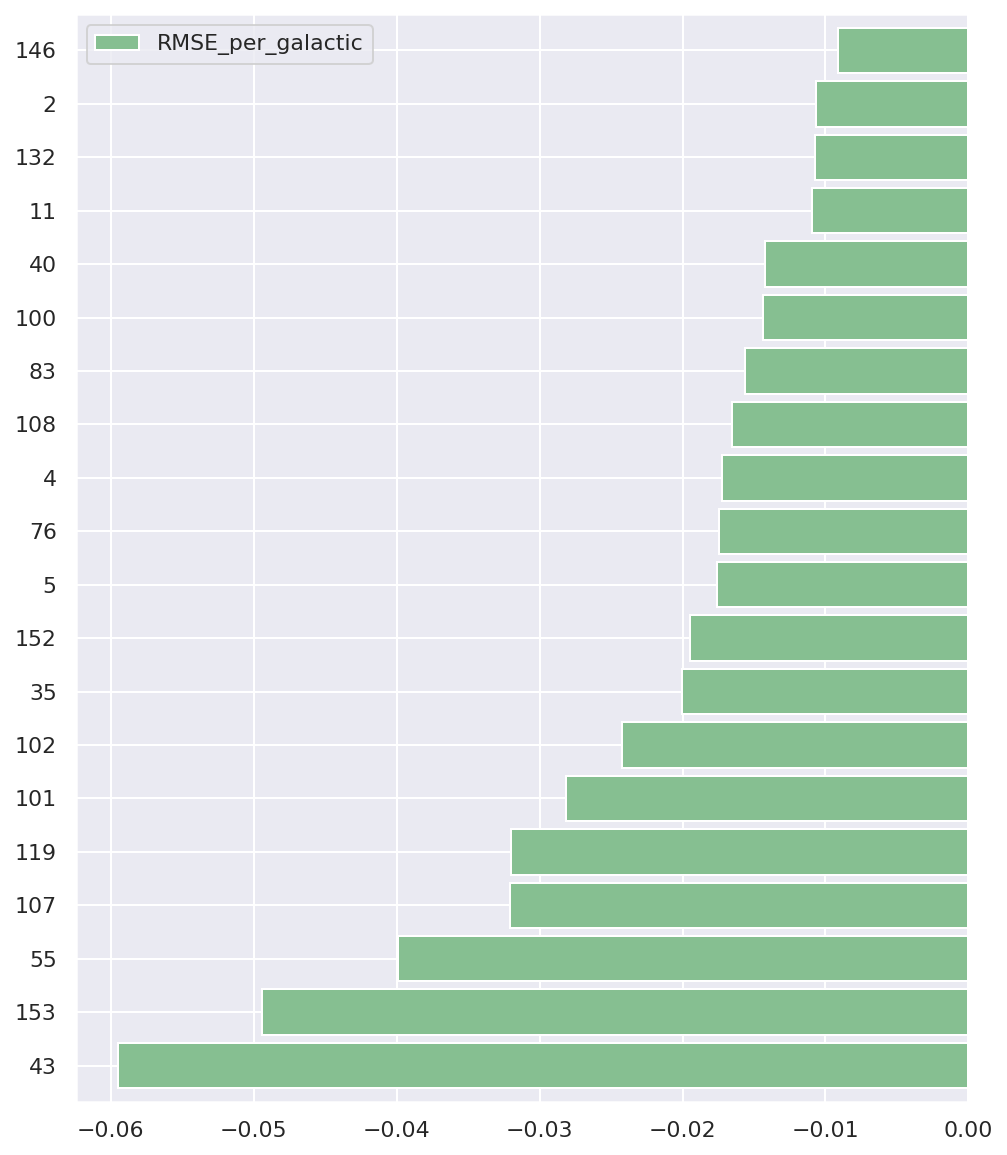

In [139]:
#Worst RMSE per galaxy
gal_rmse = gal_rmse.sort_values(by='RMSE_per_galactic')
gal_rmse.head(20).plot(kind='barh', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

Trend of target variable for every galactic

In [141]:
# for gal in train_gal:
#   df_train[df_train['galaxy'] == gal].plot(x = 'galactic year', y = 'y', xticks = df_train['galactic year'].unique(),figsize=(10, 8), marker='o', rot = 90)

#Imputing test data frame

##Filling Intergalactic Development Index (IDI)

In [ ]:
#Заполняем Expected years of education (galactic years), Mean years of education (galactic years) и Gross capital formation (% of GGP) мианами по галактикам
df_test['Gross income per capita'] = df_test.groupby('galaxy')['Gross income per capita'].apply(lambda x: x.fillna(x.mean()))
df_test['Mean years of education (galactic years)'] = df_test.groupby('galaxy')['Mean years of education (galactic years)'].apply(lambda x: x.fillna(x.mean()))
df_test['Expected years of education (galactic years)'] = df_test.groupby('galaxy')['Expected years of education (galactic years)'].apply(lambda x: x.fillna(x.mean()))
df_test['existence expectancy at birth'] = df_test.groupby('galaxy')['existence expectancy at birth'].apply(lambda x: x.fillna(x.mean()))

In [ ]:
# Заполняем Education Index
min_val_exp = 5
min_val_mean = 2
max_val_exp = 30
max_val_mean = 22
df_test['Expected years of education index'] = (df_test['Expected years of education (galactic years)'] - min_val_exp)/(max_val_exp - min_val_exp)
df_test['Mean years of education index'] = (df_test['Mean years of education (galactic years)'] - min_val_mean)/(max_val_mean - min_val_mean)
df_test['Education Index'] = df_test.groupby('galaxy')['Education Index'].fillna((df_test['Expected years of education index'] + df_test['Mean years of education index'])/2)

In [ ]:
# Заполняем Income Index
min_val_gi_per_capita = 1000
max_val_gi_per_capita = 75000
df_test['Income Index'] = df_test.groupby('galaxy')['Income Index'].fillna((np.log(df_test['Gross income per capita']) - np.log(min_val_gi_per_capita))/(max_val_gi_per_capita - min_val_gi_per_capita))

In [ ]:
#Создаем Health Index
df_test['Health Index'] = (df_test['existence expectancy at birth'] - 30)/(100 - 30)

In [ ]:
#Заполняем Intergalactic Development Index (IDI)  
df_test['Intergalactic Development Index (IDI)'] = df_test['Intergalactic Development Index (IDI)'].fillna((df_test['Education Index'] * df_test['Income Index'] * df_test['Health Index']) ** (1/3))

##Filling some additional columns 

In [ ]:
features_to_fill = ['Intergalactic Development Index (IDI), Rank']
cols_to_reg_on = ['Intergalactic Development Index (IDI)', 'Income Index', 'Health Index', 'existence expectancy at birth', 'Education Index']

df_test_not_nan = fill_nan_with_reg(df_test, features_to_fill, cols_to_reg_on)

not_nan_cols = df_test_not_nan.columns
df_test[not_nan_cols] = df_test_not_nan[not_nan_cols]

[10:43:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
features_to_fill = ['Gross galactic product (GGP) per capita']
cols_to_reg_on = ['Gross income per capita', 'Income Index', 'Intergalactic Development Index (IDI), Rank', 'Intergalactic Development Index (IDI)']

df_test_not_nan = fill_nan_with_reg(df_test, features_to_fill, cols_to_reg_on)

not_nan_cols = df_test_not_nan.columns
df_test[not_nan_cols] = df_test_not_nan[not_nan_cols]

[10:43:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


##GDI(Gender Development Index)

###Filling Estimated female/male earned income index

In [ ]:
df_test.loc[df_test['Estimated gross galactic income per capita, female'] < 0, 'Estimated gross galactic income per capita, female'] = 100

In [ ]:
features_to_fill = ['Estimated gross galactic income per capita, male', 'Estimated gross galactic income per capita, female']
cols_to_reg_on = ['Gross income per capita', 'Gross galactic product (GGP) per capita', 'Income Index',  'Intergalactic Development Index (IDI), Rank', 'Intergalactic Development Index (IDI)']

df_test_not_nan = fill_nan_with_reg(df_test, features_to_fill, cols_to_reg_on)

not_nan_cols = df_test_not_nan.columns
df_test[not_nan_cols] = df_test_not_nan[not_nan_cols]

[10:43:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:43:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
df_test['Estimated female earned income index'] = (np.log(df_test['Estimated gross galactic income per capita, female']) - np.log(100)) / (np.log(75000) - np.log(100))
df_test['Estimated male earned income index'] = (np.log(df_test['Estimated gross galactic income per capita, male']) - np.log(100)) / (np.log(75000) - np.log(100))

###Filling Female/male health index

In [ ]:
features_to_fill_2 = ['Mortality rate, under-five (per 1,000 live births)']
cols_to_reg_on = ['existence expectancy index', 'Health Index', 'existence expectancy at birth', 'Intergalactic Development Index (IDI)']

df_test_not_nan = fill_nan_with_reg(df_test, features_to_fill_2, cols_to_reg_on)

not_nan_cols = df_test_not_nan.columns
df_test[not_nan_cols] = df_test_not_nan[not_nan_cols]

[10:46:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
features_to_fill_2 = ['Life expectancy at birth, female (galactic years)', 'Life expectancy at birth, male (galactic years)']
cols_to_reg_on = ['existence expectancy index', 'Health Index', 'existence expectancy at birth', 'Intergalactic Development Index (IDI)', 'Mortality rate, under-five (per 1,000 live births)']

df_test_not_nan = fill_nan_with_reg(df_test, features_to_fill_2, cols_to_reg_on)

not_nan_cols = df_test_not_nan.columns
df_test[not_nan_cols] = df_test_not_nan[not_nan_cols]

[10:46:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
df_test['Female health index'] = (df_test['Life expectancy at birth, female (galactic years)'] - 30) / (88 - 30)
df_test['Male health index'] = (df_test['Life expectancy at birth, male (galactic years)'] - 30) / (88 - 30)

###FillingFemale/male education index

In [ ]:
features_to_fill = ['Population with at least some secondary education (% ages 25 and older)', 'Population with at least some secondary education, female (% ages 25 and older)',
                    'Population with at least some secondary education, male (% ages 25 and older)']
cols_to_reg_on = ['Mean years of education index', 'Education Index', 'Intergalactic Development Index (IDI)']

df_test_not_nan = fill_nan_with_reg(df_test, features_to_fill, cols_to_reg_on)

not_nan_cols = df_test_not_nan.columns
df_test[not_nan_cols] = df_test_not_nan[not_nan_cols]

[10:46:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
features_to_fill = ['Mean years of education, female (galactic years)', 'Mean years of education, male (galactic years)',
                    'Expected years of education, female (galactic years)', 'Expected years of education, male (galactic years)']
cols_to_reg_on = ['Mean years of education index', 'Population with at least some secondary education, female (% ages 25 and older)', 'Education Index', 
                  'Population with at least some secondary education (% ages 25 and older)', 'Population with at least some secondary education, male (% ages 25 and older)', 
                  'Intergalactic Development Index (IDI)']

df_test_not_nan = fill_nan_with_reg(df_test, features_to_fill, cols_to_reg_on)

not_nan_cols = df_test_not_nan.columns
df_test[not_nan_cols] = df_test_not_nan[not_nan_cols]

[10:46:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
df_test['Female education index'] = ((df_test['Expected years of education, female (galactic years)']/25) + (df_test['Mean years of education, female (galactic years)']/18))/2
df_test['Male education index'] = ((df_test['Expected years of education, male (galactic years)']/25) + (df_test['Mean years of education, male (galactic years)']/18))/2

In [ ]:
def fill_with_gmean(data, feature, gmean_vals):
  na_index = data[data.loc[:,feature].isnull()][feature].index
  gmean_arr = gmean_vals

  ser = pd.Series(gmean_arr[na_index], index = na_index)
  feature_with_no_na = data[data.loc[:,feature].notnull()][feature].append(ser).sort_index()

  return feature_with_no_na

In [ ]:
male_gmean = gmean(df_test.loc[:,['Male education index', 'Male health index', 'Estimated male earned income index']], axis = 1)
female_gmean = gmean(df_test.loc[:,['Female education index', 'Female health index', 'Estimated female earned income index']], axis = 1)

In [ ]:
df_test['Intergalactic Development Index (IDI), male'] = fill_with_gmean(df_test, 'Intergalactic Development Index (IDI), male', male_gmean)
df_test['Intergalactic Development Index (IDI), female'] = fill_with_gmean(df_test, 'Intergalactic Development Index (IDI), female', female_gmean)

In [ ]:
df_test['Gender Development Index (GDI)'] = df_test['Gender Development Index (GDI)'].fillna(df_test['Intergalactic Development Index (IDI), male'] / df_test['Intergalactic Development Index (IDI), female'])

##Filling GII

In [ ]:
features_to_fill = ['Young age (0-14) dependency ratio (per 100 creatures ages 15-64)']
cols_to_reg_on = ['Intergalactic Development Index (IDI), female', 'Intergalactic Development Index (IDI), male', 'Female education index',
                  'Intergalactic Development Index (IDI)', 'Female health index', 'Life expectancy at birth, female (galactic years)', 'Gender Inequality Index (GII)','Male education index']

df_test_not_nan = fill_nan_with_reg(df_test, features_to_fill, cols_to_reg_on)

not_nan_cols = df_test_not_nan.columns
df_test[not_nan_cols] = df_test_not_nan[not_nan_cols]

[10:46:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
features_to_fill = ['Maternal mortality ratio (deaths per 100,000 live births)']
cols_to_reg_on = ['Mortality rate, under-five (per 1,000 live births)', 'Female health index', 'Life expectancy at birth, female (galactic years)',
 'existence expectancy at birth', 'Health Index', 'existence expectancy index', 'Life expectancy at birth, male (galactic years)', 'Male health index']

df_test_not_nan = fill_nan_with_reg(df_test, features_to_fill, cols_to_reg_on)
not_nan_cols = df_test_not_nan.columns
df_test[not_nan_cols] = df_test_not_nan[not_nan_cols]

[10:46:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
features_to_fill = ['Adolescent birth rate (births per 1,000 female creatures ages 15-19)']
cols_to_reg_on = ['Mortality rate, under-five (per 1,000 live births)', 'Young age (0-14) dependency ratio (per 100 creatures ages 15-64)', 'existence expectancy at birth',
 'Health Index', 'Life expectancy at birth, female (galactic years)', 'Female health index', 'Intergalactic Development Index (IDI), male']

df_test_not_nan = fill_nan_with_reg(df_test, features_to_fill, cols_to_reg_on)
not_nan_cols = df_test_not_nan.columns
df_test[not_nan_cols] = df_test_not_nan[not_nan_cols]

[10:46:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
features_to_fill = ['Interstellar Data Net users, total (% of population)']
cols_to_reg_on = ['Intergalactic Development Index (IDI), male', 'Male education index', 'Intergalactic Development Index (IDI), female', 'Female education index',
 'Intergalactic Development Index (IDI)', 'Education Index']

df_test_not_nan = fill_nan_with_reg(df_test, features_to_fill, cols_to_reg_on)
not_nan_cols = df_test_not_nan.columns
df_test[not_nan_cols] = df_test_not_nan[not_nan_cols]

[10:46:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
features_to_fill = ['Share of seats in senate (% held by female)']
cols_to_reg_on = [ 'Interstellar Data Net users, total (% of population)', 'galactic year', 'Expected years of education, male (galactic years)', 'Expected years of education (galactic years)',
 'Expected years of education index', 'Expected years of education, female (galactic years)', 'Education Index']

df_test_not_nan = fill_nan_with_reg(df_test, features_to_fill, cols_to_reg_on)
not_nan_cols = df_test_not_nan.columns
df_test[not_nan_cols] = df_test_not_nan[not_nan_cols]

[10:46:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
features_to_fill = ['Labour force participation rate (% ages 15 and older), male', 'Labour force participation rate (% ages 15 and older), female']
cols_to_reg_on = ['Population with at least some secondary education (% ages 25 and older)', 'Mean years of education, male (galactic years)',
                  'Population with at least some secondary education, male (% ages 25 and older)','Male education index','Mean years of education (galactic years)',
                  'Mean years of education index', 'Population with at least some secondary education, female (% ages 25 and older)', 'Education Index']

df_test_not_nan = fill_nan_with_reg(df_test, features_to_fill, cols_to_reg_on)
not_nan_cols = df_test_not_nan.columns
df_test[not_nan_cols] = df_test_not_nan[not_nan_cols]

[10:46:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
df_test['Share of seats in senate (% held by male)'] = (1 - df_test['Share of seats in senate (% held by female)'] / 100) * 100

Reproductive_health_index_female = np.sqrt((10/df_test['Maternal mortality ratio (deaths per 100,000 live births)'])*(1/df_test['Adolescent birth rate (births per 1,000 female creatures ages 15-19)']))
Reproductive_health_index_male = [1] * df_test.shape[0]

Empowerment_index_female = np.sqrt((df_test['Share of seats in senate (% held by female)'] / 100)*(df_test['Population with at least some secondary education, female (% ages 25 and older)'] / 100))
Empowerment_index_male = np.sqrt((df_test['Share of seats in senate (% held by male)'] / 100)*(df_test['Population with at least some secondary education, male (% ages 25 and older)'] / 100))

Labour_Market_Index_female = df_test['Labour force participation rate (% ages 15 and older), female'] /100
Labour_Market_Index_male = df_test['Labour force participation rate (% ages 15 and older), male'] / 100


Gender_indices_female =  (Reproductive_health_index_female * Empowerment_index_female * Labour_Market_Index_female) ** (1/3)
Gender_indices_male = (Reproductive_health_index_male * Empowerment_index_male * Labour_Market_Index_male) ** (1/3)


Accounting_inequality = pd.Series(hmean(pd.DataFrame(zip(Gender_indices_female, Gender_indices_male)), axis=1))

Treating_equally = (((Reproductive_health_index_female + Reproductive_health_index_male)/2)*
                    ((Empowerment_index_female + Empowerment_index_male)/2)*
                    ((Labour_Market_Index_female+Labour_Market_Index_male)/2))**(1/3)


df_test['Gender Inequality Index (GII)'] = df_test['Gender Inequality Index (GII)'].fillna(1 - (Accounting_inequality / Treating_equally))

In [ ]:
features_to_fill = ['Intergalactic Development Index (IDI), male, Rank', 'Intergalactic Development Index (IDI), female, Rank']
cols_to_reg_on = ['Intergalactic Development Index (IDI), Rank','Intergalactic Development Index (IDI), female, Rank','Intergalactic Development Index (IDI), male',
 'Intergalactic Development Index (IDI)','Income Index','Intergalactic Development Index (IDI), female','Male education index','Health Index',
 'existence expectancy at birth','Female education index','Life expectancy at birth, female (galactic years)','Female health index',
 'Education Index','Male health index','Life expectancy at birth, male (galactic years)','existence expectancy index']

df_test_not_nan = fill_nan_with_reg(df_test, features_to_fill, cols_to_reg_on)
not_nan_cols = df_test_not_nan.columns
df_test[not_nan_cols] = df_test_not_nan[not_nan_cols]

[10:46:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


#Predictions

In [142]:
def test_loop(data, test_data):
    labels = data['y']
    data = data.drop('galaxy', axis=1)    
    data = data.drop('y', axis=1)


    columns = ['galactic year','Intergalactic Development Index (IDI), Rank', 'Gender Inequality Index (GII)',
                        'Gender Inequality Index (GII)','Interstellar Data Net users, total (% of population)']

    train_labels = labels
    train_data = data[columns]
    test_data = test_data[columns]

    scaler = StandardScaler().fit(train_data)
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)

    model = XGBRegressor(silent = True).fit(train_data, train_labels)
    predictions = model.predict(test_data)

    return predictions

In [ ]:
#Data frame for predictions
df_test = df_test.sort_values(by=['galaxy'])
test_pred = pd.DataFrame(0, index=np.arange(len(df_test)), columns=["predicted_y"])

In [ ]:
i=0
test_gal = np.sort(df_test['galaxy'].unique())

for gal in test_gal:
    count = len(df_test.loc[df_test['galaxy'] == gal])
    data = df_train.loc[df_train['galaxy'] == gal]
    test_data = df_test.loc[df_test['galaxy'] == gal]
    pred = test_loop(data, test_data)
    test_pred.loc[i:i+count-1,'predicted_y'] = pred
    i=i+count

[11:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
df_test["predicted_y"] = test_pred.to_numpy()
df_test.sort_index(inplace=True)
predictions = df_test["predicted_y"]

#Optimization part
For optimization part i allocated 100z DSML to every galaxy in top 500 by their potential.

In [ ]:
index = predictions
pot_inc = -np.log(index+0.01)+3
p2 = pot_inc**2

In [ ]:
ss = pd.DataFrame({
    'Index': df_test.index,
    'pred': predictions,
    'opt_pred': 0,
    'eei': df_test['existence expectancy index'], # So we can split into low and high EEI galaxies
})

In [ ]:
ss.loc[p2.nlargest(400).index, 'opt_pred'] = 100
ss = ss.sort_values('pred')
ss.iloc[400:600].opt_pred = 50
ss = ss.sort_index()

In [ ]:
# increase = (ss['opt_pred']*p2)/1000
# print(sum(increase), ss.loc[ss.eei < 0.7, 'opt_pred'].sum(), ss['opt_pred'].sum())

#Submission

In [ ]:
ss[['Index', 'pred', 'opt_pred']].to_csv('submission.csv', index=False)

#Results and thoughts:
*   What was tried:
  *   Filling missing values with mean/median;
  *   Training and predicting on full dataset;
  *   Predictinng using top correletad features only (tried from 2 to 20 features);
  *   Predicting using XGBoost feature importance;
  *   Predicting using shift of target variable(lag) and using differences between years;
  *   Clustering galaxies and predicting on that clusters;
  *   Various machine learning models: Lasso/Ridge regression, Random Forest, Gradient Boosting Tree, XGBoost, LightGBM, CatBoost;
  *   Ensembling and stacking of models;
  *   Solving optimization part using scipy package for optimization.  

*   As the result, the solution that is provided in current notebook got me 178th place out of 900+ participants;
*   As it occured, optimization part played a great role in final score on leaderboard. People that got approximatly the same score as i, after improving their optimization part, moved into top 10 - top 20. 
*   Overall it was a great experience for me especially because prohack was my first data science competition. It was really exciting to test different ideas and methods throught the contest and then to analyze others notebooks. Hope to participate next year.
